In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchtext.datasets import IWSLT 
from torchtext.data import Field, BucketIterator
import numpy as np
import spacy
import random

import seaborn as sns
import matplotlib.pyplot as plt

from torch.nn import TransformerEncoder, TransformerEncoderLayer
from torch.nn import TransformerDecoder, TransformerDecoderLayer
import torch.nn.functional as F

import warnings
warnings.filterwarnings("ignore")

# <b>Loading the data</b>

In [2]:
CFG = {"IN_LANG":"de", "OUT_LANG": "en"}

In [3]:
import spacy.cli
import en_core_web_sm
import de_core_news_sm


spacy.cli.download("en_core_web_sm")
spacy.cli.download("de_core_news_sm")


if CFG["IN_LANG"] == "en":
    spacy_in_lang = en_core_web_sm.load()
    spacy_out_lang = de_core_news_sm.load()
else:
    spacy_in_lang = de_core_news_sm.load()
    spacy_out_lang = en_core_web_sm.load()
    

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Download and installation successful
You can now load the model via spacy.load('de_core_news_sm')


In [4]:
def tokenizer_in(text):
    return [tok.text for tok in spacy_in_lang.tokenizer(text)]

def tokenizer_out(text):
    return [tok.text for tok in spacy_out_lang.tokenizer(text)]

in_lang = Field(tokenize=tokenizer_in, lower=True)
out_lang = Field(tokenize=tokenizer_out, lower=True, init_token="<sos>", eos_token="<eos>")

In [5]:
MAX_LEN = 25

train_data, valid_data, test_data = IWSLT.splits(
        exts=("."+CFG["IN_LANG"], "."+CFG["OUT_LANG"]), fields=(in_lang, out_lang ) ,filter_pred=lambda x: len(vars(x)['src']) <= MAX_LEN and 
            len(vars(x)['trg']) <= MAX_LEN)

In [6]:
in_lang.build_vocab(train_data, min_freq=2)
out_lang.build_vocab(train_data, min_freq=2)

In [7]:
def sample_example(): #Gives example from the dataset with its target (For visualizing attention weights)
    
    i = np.random.randint(0,len(valid_data))
    
    sentence = valid_data[i].src
    target_sentence = valid_data[i].trg

    target_sentence.insert(0,"<sos>")
    target_sentence = target_sentence + ["<eos>"]
    
    return sentence, target_sentence

In [8]:
in_pad_idx = in_lang.vocab.stoi['<pad>']
out_pad_idx = out_lang.vocab.stoi['<pad>']

# <b> Loading and preparing Transformer model </b>

In [9]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        self.scale = nn.Parameter(torch.ones(1))

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(
            0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.scale * self.pe[:x.size(0), :]
        return self.dropout(x)

In [10]:
class TransformerModel(nn.Module):
    
    def __init__(self, intoken, outtoken ,hidden, enc_layers=2, dec_layers=2, dropout=.1, nheads=2, ff_model=128):
        super(TransformerModel, self).__init__()
        
        self.encoder = nn.Embedding(intoken, hidden)
        self.pos_encoder = PositionalEncoding(hidden, dropout)

        self.decoder = nn.Embedding(outtoken, hidden) 
        self.pos_decoder = PositionalEncoding(hidden, dropout)
        
        
        encoder_layers = TransformerEncoderLayer(d_model=hidden, nhead = nheads, dim_feedforward = ff_model, dropout=dropout, activation='relu')
        self.transformer_encoder = TransformerEncoder(encoder_layers, enc_layers)

        encoder_layers = TransformerDecoderLayer(hidden, nheads, ff_model, dropout, activation='relu')
        self.transformer_decoder = TransformerDecoder(encoder_layers, dec_layers)        

        self.fc_out = nn.Linear(hidden, outtoken)

        self.src_mask = None
        self.trg_mask = None
        self.memory_mask = None

        
    def generate_square_subsequent_mask(self, sz, sz1=None):
        
        if sz1 == None:
            mask = torch.triu(torch.ones(sz, sz), 1)
        else:
            mask = torch.triu(torch.ones(sz, sz1), 1)
            
        return mask.masked_fill(mask==1, float('-inf'))

    def make_len_mask_enc(self, inp):
        return (inp == in_pad_idx).transpose(0, 1)   #(batch_size, output_seq_len)
    
    def make_len_mask_dec(self, inp):
        return (inp == out_pad_idx).transpose(0, 1) #(batch_size, input_seq_len)
    


    def forward(self, src, trg): #SRC: (seq_len, batch_size)

        if self.trg_mask is None or self.trg_mask.size(0) != len(trg):
            self.trg_mask = self.generate_square_subsequent_mask(len(trg)).to(trg.device)
            

        #Adding padding mask
        src_pad_mask = self.make_len_mask_enc(src)
        trg_pad_mask = self.make_len_mask_dec(trg)
             

        #Add embeddings Encoder
        src = self.encoder(src)  #Embedding, (seq_len, batch_size, d_model)
        src = self.pos_encoder(src)   #Pos embedding
        
        
        #Add embedding decoder
        trg = self.decoder(trg) #(seq_len, batch_size, d_model)
        trg = self.pos_decoder(trg)

        
        memory = self.transformer_encoder(src, None, src_pad_mask)
        output = self.transformer_decoder(tgt = trg, memory = memory, tgt_mask = self.trg_mask, memory_mask = None, 
                                          tgt_key_padding_mask = trg_pad_mask, memory_key_padding_mask = src_pad_mask)

        output = self.fc_out(output)

        return output

In [11]:
import math

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#Model Hyperparameter
input_size_encoder = len(in_lang.vocab)
input_size_decoder = len(out_lang.vocab)
output_size = len(out_lang.vocab)

d_model = 256


transformer_model = TransformerModel(input_size_encoder, input_size_decoder ,d_model, enc_layers=1, dec_layers=1, dropout=.1, nheads=1, ff_model=1028).to(device)
transformer_model.load_state_dict(torch.load("../models/transformer"))

<All keys matched successfully>

In [12]:
def get_out_encoder_transformer(src, model):  #Get the transformer memory out of the encoder
    
    model.eval()
    tokens = src
    
    tokens.append(in_lang.eos_token)

    text_to_indices = [in_lang.vocab.stoi[token] for token in tokens]

    # Convert to Tensor
    sentence_tensor = torch.LongTensor(text_to_indices).unsqueeze(1).to(device)    

    with torch.no_grad():
        
        emb_src = model.encoder(sentence_tensor)
        emb_src = model.pos_encoder(emb_src)

        memory = model.transformer_encoder(emb_src)

        return memory

In [13]:
def get_att_weights_transformer(model, source): #Source and target sentence tokenized
    
    model.eval()
    
    memory = get_out_encoder_transformer(source, model)
    decoder = model.transformer_decoder.layers[0]
    
    #Transformer decoder original codee   
    preds = [out_lang.vocab.stoi[out_lang.init_token]]

    for i in range(50):

        tgt = torch.Tensor(preds).long().unsqueeze(1).to(device)
        tgt = model.decoder(tgt)
        tgt = model.pos_decoder(tgt)

        tgt2, _ = decoder.self_attn(tgt, tgt, tgt)
        tgt = tgt + decoder.dropout1(tgt2)
        tgt = decoder.norm1(tgt)
        tgt2, att_weights = decoder.multihead_attn(tgt, memory, memory)

        tgt = tgt + decoder.dropout2(tgt2)
        tgt = decoder.norm2(tgt)
        tgt2 = decoder.linear2(decoder.dropout(decoder.activation(decoder.linear1(tgt))))
        tgt = tgt + decoder.dropout3(tgt2)
        out = decoder.norm3(tgt)


        out = model.fc_out(out)   

        words = out[-1].argmax(-1).reshape(-1).detach().cpu().numpy()
        preds.append(words[0])

        if words[0] == out_lang.vocab.stoi["<eos>"]:
            break



    preds = [out_lang.vocab.itos[i] for i in preds]
    att_weights = att_weights[0].detach().cpu().numpy()

    return att_weights, preds[1:]
        

In [14]:
def translate_sentence_transformer(model, sentence, max_length=50):
    model.eval()
    tokens = [token.text.lower() for token in spacy_in_lang(sentence)]

    text_to_indices = [in_lang.vocab.stoi[token] for token in tokens]

    # Convert to Tensor
    sentence_tensor = torch.LongTensor(text_to_indices).unsqueeze(1).to(device)

    preds = [out_lang.vocab.stoi[out_lang.init_token]]

    with torch.no_grad():
        
        emb_src = model.encoder(sentence_tensor)
        emb_src = model.pos_encoder(emb_src)

        memory = model.transformer_encoder(emb_src)

        for i in range(50):

            trg = torch.Tensor(preds).long().unsqueeze(1).to(device)
            trg = model.decoder(trg)
            trg = model.pos_decoder(trg)

            out = model.transformer_decoder(tgt = trg, memory = memory)
            out = model.fc_out(out)
            
            

            new = out.squeeze(1)[-1].argmax().item()
            preds.append(new)
            if new == out_lang.vocab.stoi["<eos>"]:
                break

    
    return " ".join([out_lang.vocab.itos[i] for i in preds][1:-1])

# <b>Loading and preparing RNN model</b>

In [15]:
class Encoder(nn.Module): 
    def __init__(self, input_size, embedding_size, hidden_size, num_layers, p):
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.embedding = nn.Embedding(input_size, embedding_size)
        self.rnn = nn.GRU(embedding_size, hidden_size, num_layers, bidirectional=True)

        self.fc_hidden = nn.Linear(hidden_size * 2, hidden_size)
        self.dropout = nn.Dropout(p)

    def forward(self, x):

        embedding = self.dropout(self.embedding(x))
        encoder_states, hidden = self.rnn(embedding)

        hidden = self.fc_hidden(torch.cat((hidden[0:1], hidden[1:2]), dim=2))

        return encoder_states, hidden


In [16]:
class Decoder(nn.Module):
    def __init__(self, input_size, embedding_size, hidden_size, output_size, num_layers, p):
        
        super(Decoder, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.embedding = nn.Embedding(input_size, embedding_size)
        self.rnn = nn.GRU(hidden_size * 2 + embedding_size, hidden_size, num_layers)

        self.energy = nn.Linear(hidden_size, 1)
        self.fc = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(p)
        self.softmax = nn.Softmax(dim=0)
        
        self.fc_key = nn.Linear(hidden_size, hidden_size)
        self.fc_query = nn.Linear(hidden_size*2, hidden_size)

    def forward(self, x, encoder_states, hidden):
        
        x = x.unsqueeze(0)
        embedding = self.dropout(self.embedding(x))
        
        key = self.fc_key(hidden)
        query = self.fc_query(encoder_states)
        
        #Additive attention
        energy = key+query
        energy = self.energy(torch.tanh(energy))
        attention = self.softmax(energy)

        # Apply attention weights
        context_vector = torch.einsum("snk,snl->knl", attention, encoder_states)

        rnn_input = torch.cat((context_vector, embedding), dim=2)
        outputs, hidden = self.rnn(rnn_input, hidden)
        
        predictions = self.fc(outputs).squeeze(0)

        return predictions, hidden, attention


class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, source, target, teacher_force_ratio=1):
        batch_size = source.shape[1]
        target_len = target.shape[0]
        target_vocab_size = len(out_lang.vocab)

        outputs = torch.zeros(target_len, batch_size, target_vocab_size).to(device)
        encoder_states, hidden = self.encoder(source)
        x = target[0]

        for t in range(1, target_len):

            output, hidden = self.decoder(x, encoder_states, hidden)
            outputs[t] = output
            
            best_guess = output.argmax(1)
            x = target[t] if random.random() < teacher_force_ratio else best_guess

        return outputs


In [17]:
num_layers = 1
dropout = 0.1

d_model=256

encoder_embedding_size = d_model
decoder_embedding_size = d_model
hidden_size = d_model



encoder_net = Encoder(input_size_encoder, encoder_embedding_size, 
                      hidden_size, num_layers, dropout).to(device)

decoder_net = Decoder(input_size_decoder, decoder_embedding_size, 
                      hidden_size, output_size, num_layers, dropout).to(device)

rnn_model = Seq2Seq(encoder_net, decoder_net).to(device)
rnn_model.load_state_dict(torch.load("../models/rnn_model"))

<All keys matched successfully>

In [18]:
def get_att_weights_bahdanau(model, sentence, max_length=50):
    
    model.eval()

    target_encoded = [out_lang.vocab.stoi[target_sentence[i]] for i in range(len(target_sentence))]
    tokens = sentence

    text_to_indices = [in_lang.vocab.stoi[token] for token in tokens]
    sentence_tensor = torch.LongTensor(text_to_indices).unsqueeze(1).to(device)

    preds = [out_lang.vocab.stoi[out_lang.init_token]]
    attention = np.empty((0,len(tokens)))

    with torch.no_grad():
        
        encoder_states, hidden = model.encoder(sentence_tensor)
        
        for t in range(max_length):
                    
            trg = torch.Tensor([preds[-1]]).long().to(device)

            output, hidden, att_weights = model.decoder(trg, encoder_states, hidden)
            att_weights = att_weights.squeeze().detach().cpu().numpy()
  
            attention = np.vstack((attention,att_weights))
            new = output.argmax(1).item()

            preds.append(new)
            
            if new == out_lang.vocab.stoi["<eos>"]:
                break
            
        
    return attention, [out_lang.vocab.itos[i] for i in preds][1:]

---------

# Visualizing the weights

In [19]:
translate_sentence_transformer(transformer_model, "Ich möchte etwas essen gehen, weil ich hungrig bin.", max_length=50)

"i want to eat something , because i 'm hungry ."

In [20]:
sentence, target_sentence = sample_example()

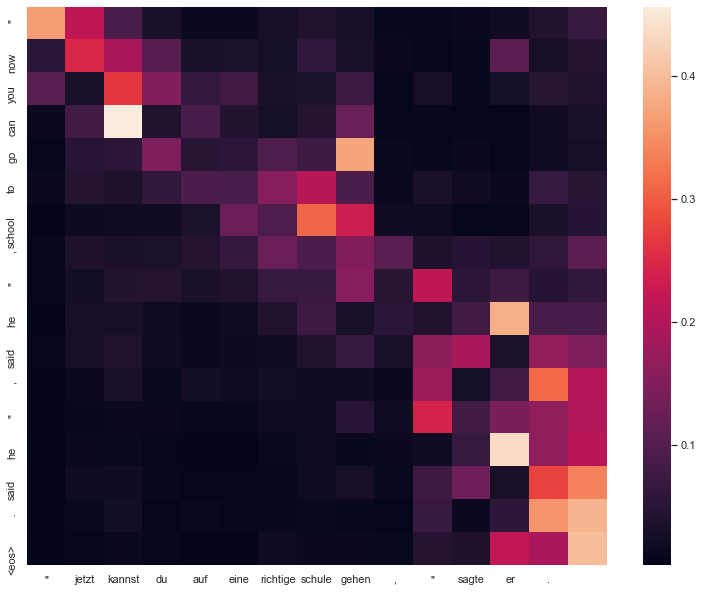

In [21]:
att_weights, tr_preds = get_att_weights_transformer(transformer_model, sentence)

sns.set(rc={'figure.figsize':(13,10.27)})
sns.heatmap(att_weights, xticklabels=sentence, yticklabels=tr_preds)

plt.show()

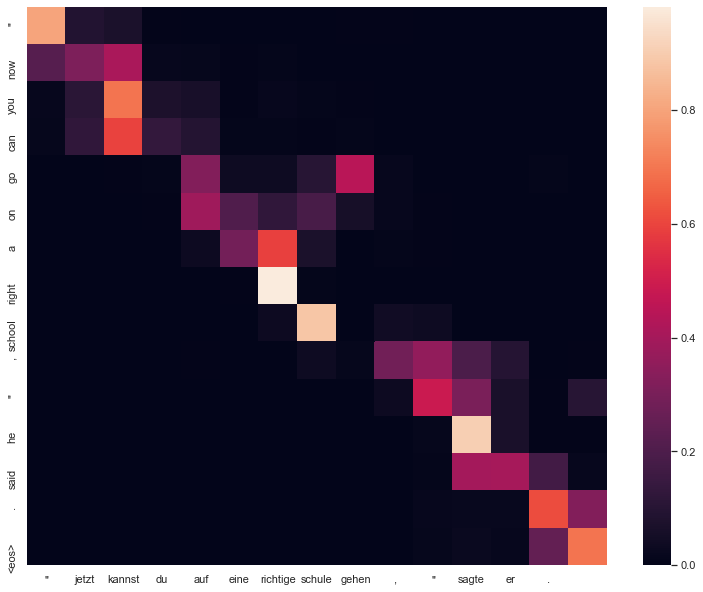

In [22]:
att_weights, rnn_preds = get_att_weights_bahdanau(rnn_model, sentence)

sns.set(rc={'figure.figsize':(13,10.27)})
sns.heatmap(att_weights, xticklabels=sentence, yticklabels=rnn_preds)

plt.show()

In [23]:
import pandas as pd 

pd.DataFrame([target_sentence[1:-1], tr_preds[:-1], rnn_preds[:-1]], index=["Source", "Transformer", "RNN"])

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
Source,"""",you,can,go,to,a,real,school,now,",","""",he,said,.,None,None
Transformer,"""",now,you,can,go,to,school,",","""",he,said,",","""",he,said,.
RNN,"""",now,you,can,go,on,a,right,school,",","""",he,said,.,None,None
